# Serve TensorFlow Model Predictions with TensorFlow Serving (TFS)

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/serving/).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://www.tensorflow.org/tutorials/keras/basic_classification).

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


# Build the Model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


# Train and Evaluate the Model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [3]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 4s 67us/sample - loss: 0.5375 - acc: 0.8111
Epoch 2/5
60000/60000 [==============================] - 4s 65us/sample - loss: 0.4053 - acc: 0.8564
Epoch 3/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.3703 - acc: 0.8698
Epoch 4/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.3501 - acc: 0.875

# Save the Model in the TensorFlow SavedModel Format

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  TensorFlow Serving allows us to select [which version of a model, or "servable"](../overview) we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [4]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


Saved model:
total 116
-rw-r--r-- 1 root root 118462 Aug 22 23:31 saved_model.pb
drwxr-xr-x 2 root root     66 Aug 22 23:31 variables


# Examine the Saved Model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://www.tensorflow.org/guide/saved_model#cli_to_inspect_and_execute_savedmodel) in the TensorFlow Guide.

In [5]:
!saved_model_cli show --dir {export_path} --all

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

That tells us a lot about our model!  In this case we just trained our model, so we already know the inputs and outputs, but if we didn't this would be important information.  It doesn't tell us everything, like the fact that this is grayscale image data for example, but it's a great start.

# Install TensorFlow Serving in this Notebook

### Add TensorFlow Serving Distribution URI

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [6]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   9821      0 --:--:-- --:--:-- --:--:--  9842
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [341 B]
Hit:3 http://ppa.launchpad.net/openjdk-r/ppa/ubuntu xenial InRelease           
Get:4 http://security.ubuntu.com/ubuntu xenial-security InRelease [109 kB]     
Get:5 https://packages.cloud.google.com/apt cloud-sdk-xenial InRelease [6,384 B]
Get:6 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [349 B]
Get:7 https://packages.cloud.google.com/apt cloud-sdk-xenial/main amd64 Pac

In [7]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 149 not upgraded.
Need to get 210 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.3.0 [210 MB]
Fetched 210 MB in 2s (88.3 MB/s)                  
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 55956 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.3.0_all.deb ...
Unpacking tensorflow-model-server (2.3.0) ...
Setting up tensorflow-model-server (2.3.0) ...


# Start TensorFlow Serving in this Notebook

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [8]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [9]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [10]:
!tail server.log

2020-08-22 23:33:30.171605: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-08-22 23:33:30.188911: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:199] Restoring SavedModel bundle.
2020-08-22 23:33:30.201739: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:303] SavedModel load for tags { serve }; Status: success: OK. Took 31773 microseconds.
2020-08-22 23:33:30.202182: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-08-22 23:33:30.202446: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
202

# Prepare Sample Prediction Inputs

First, let's take a look at a random example from our test data.

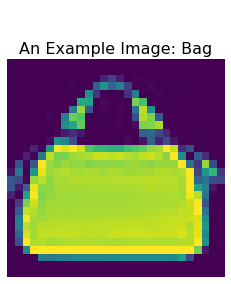

In [11]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [12]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


# Make a Prediction Request with our Sample Prediction Input using TensorFlow Serving
We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

You are using pip version 19.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


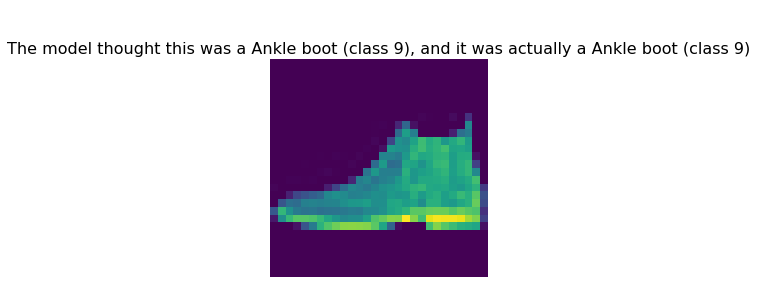

In [13]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], test_labels[0], class_names[np.argmax(predictions[0])], test_labels[0]))

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.

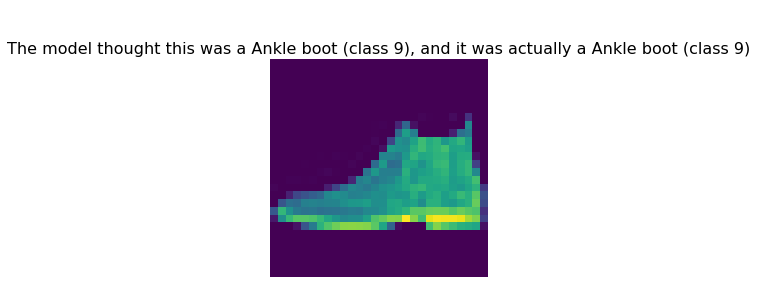

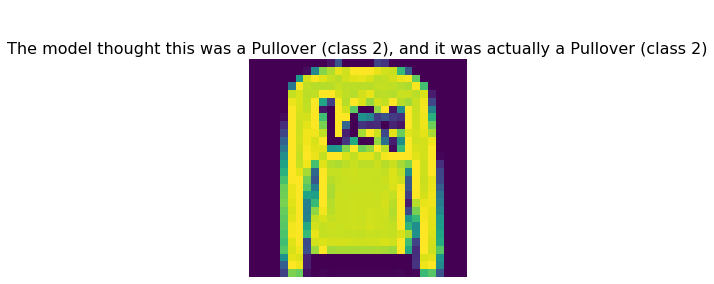

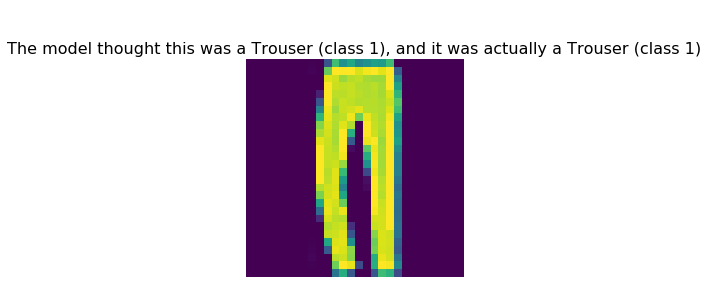

In [14]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], test_labels[i], class_names[np.argmax(predictions[i])], test_labels[i]))

# Stop the TensorFlow Model Server to Preserve System Resources in our Notebook

In [15]:
!ps -aef | grep tensorflow_model_server

root      5027  5025  4 23:33 ?        00:00:00 tensorflow_model_server --rest_api_port=8501 --model_name=fashion_model --model_base_path=/tmp
root      5085  4417  0 23:33 pts/1    00:00:00 /bin/sh -c ps -aef | grep tensorflow_model_server
root      5087  5085  0 23:33 pts/1    00:00:00 grep tensorflow_model_server


In [16]:
!pkill tensorflow